In [1]:
import yfinance as yf
import datetime as dt
import pandas_datareader as pdr
import pandas as pd
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, Flatten, MaxPooling1D

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\FileBase")

from root_functions import add_indicators, up_down, full_prediction, result

## Descarga datos y creación dataset

In [3]:
sample_per = 400
stock = 'EURGBP=X'

end = dt.date.today()- dt.timedelta(days=2)
start = end - dt.timedelta(days=(sample_per))
interval = '1h'

In [4]:
database = yf.download(stock, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [5]:
#Añadimos indicadores

ema1=200
ema2=50
ema3=20

data_base = add_indicators(database)

#Añadimos columna up_down
data_base = up_down(data_base)

#Listado indicadores
data_base.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'log_ret', 'Up_Down'],
      dtype='object')

In [6]:
data_base

,Open,High,Low,Close,Adj Close,Volume,200ema,50ema,20ema,14-high,...,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR,log_ret,Up_Down
2020-07-27 00:00:00+01:00,0.91079,0.91103,0.91010,0.91047,0.91047,0,0.910470,0.910470,0.910470,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2020-07-27 01:00:00+01:00,0.91045,0.91244,0.91010,0.91188,0.91188,0,0.911179,0.910525,0.910604,NaN,...,NaN,-0.912440,NaN,NaN,NaN,NaN,NaN,NaN,0.001549,1
2020-07-27 02:00:00+01:00,0.91193,0.91200,0.91090,0.91128,0.91128,0,0.911213,0.910555,0.910669,NaN,...,NaN,-0.912440,NaN,NaN,NaN,NaN,NaN,NaN,-0.000658,-1
2020-07-27 03:00:00+01:00,0.91135,0.91170,0.91050,0.91141,0.91141,0,0.911263,0.910588,0.910739,NaN,...,NaN,-0.912440,NaN,NaN,NaN,NaN,NaN,NaN,0.000143,1
2020-07-27 04:00:00+01:00,0.91145,0.91206,0.91120,0.91181,0.91181,0,0.911374,0.910636,0.910841,NaN,...,NaN,-0.912393,0.910361,0.911370,0.912379,0.221493,0.717965,NaN,0.000439,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30 18:00:00+01:00,0.85766,0.85771,0.85720,0.85755,0.85755,0,0.855736,0.857211,0.857396,0.8582,...,38.361801,-0.858066,0.857299,0.857506,0.857713,0.048169,0.606581,0.000818,-0.000058,-1
2021-08-30 19:00:00+01:00,0.85740,0.85757,0.85710,0.85736,0.85736,0,0.855752,0.857217,0.857393,0.8582,...,-24.261354,-0.858040,0.857240,0.857478,0.857716,0.055461,0.251888,0.000793,-0.000222,-1
2021-08-30 20:00:00+01:00,0.85737,0.85757,0.85710,0.85749,0.85749,0,0.855769,0.857228,0.857402,0.8582,...,-16.649434,-0.858015,0.857241,0.857462,0.857683,0.051558,0.563340,0.000770,0.000152,1
2021-08-30 21:00:00+01:00,0.85748,0.85770,0.85695,0.85730,0.85730,0,0.855784,0.857230,0.857392,0.8582,...,-84.660558,-0.857991,0.857233,0.857460,0.857687,0.052861,0.146970,0.000769,-0.000222,-1


In [7]:
#Hacemos un shift a la columna Up_Down para tener el signo de la tendencia de la siguiente vela
data_base['Adj Close'] = data_base['Adj Close'].shift(-1)

data_base.dropna(inplace=True)

In [8]:
#Filtramos las columnas que nos interesan para obtener el dataset de trabajo
data = data_base.copy()

#f'{ema1}ema', f'{ema2}ema', f'{ema3}ema'
data = data[['Adj Close', f'{ema1}ema', f'{ema2}ema', f'{ema3}ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR']]


cols = data.columns

In [9]:
data

,Adj Close,200ema,50ema,20ema,14-high,14-low,%K,%D,RSI,MACD,MACDh,MACDs,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR
2020-07-28 09:00:00+01:00,0.91113,0.912072,0.911659,0.911917,0.9136,0.90970,8.205465,24.803092,36.104221,-0.000145,-0.000320,0.000175,-246.061306,-0.913891,0.909754,0.911530,0.913306,0.389675,0.074891,0.001438
2020-07-28 10:00:00+01:00,0.91122,0.912041,0.911639,0.911842,0.9136,0.90909,45.232998,27.508029,45.114528,-0.000186,-0.000289,0.000103,-163.191202,-0.913724,0.909729,0.911272,0.912815,0.338748,0.454006,0.001505
2020-07-28 11:00:00+01:00,0.90989,0.912014,0.911622,0.911783,0.9136,0.90909,47.228610,33.555691,45.782137,-0.000209,-0.000249,0.000041,-79.803956,-0.913446,0.909983,0.911032,0.912081,0.230219,0.589644,0.001495
2020-07-28 12:00:00+01:00,0.91047,0.911945,0.911554,0.911602,0.9136,0.90909,17.738482,36.733363,38.357146,-0.000331,-0.000297,-0.000034,-129.051595,-0.913184,0.909477,0.910702,0.911927,0.269061,0.168616,0.001573
2020-07-28 13:00:00+01:00,0.90810,0.911899,0.911512,0.911495,0.9136,0.90909,30.598948,31.855347,42.719971,-0.000376,-0.000274,-0.000102,-124.054582,-0.912939,0.909448,0.910546,0.911644,0.241267,0.465407,0.001562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30 17:00:00+01:00,0.85755,0.855717,0.857197,0.857380,0.8582,0.85660,62.498137,55.832464,53.553629,0.000093,0.000029,0.000064,40.310240,-0.858091,0.857266,0.857542,0.857818,0.064318,0.605128,0.000842
2021-08-30 18:00:00+01:00,0.85736,0.855736,0.857211,0.857396,0.8582,0.85660,59.376397,55.416480,52.822892,0.000095,0.000024,0.000070,38.361801,-0.858066,0.857299,0.857506,0.857713,0.048169,0.606581,0.000818
2021-08-30 19:00:00+01:00,0.85749,0.855752,0.857217,0.857393,0.8582,0.85660,47.500373,56.458302,50.026294,0.000080,0.000008,0.000072,-24.261354,-0.858040,0.857240,0.857478,0.857716,0.055461,0.251888,0.000793
2021-08-30 20:00:00+01:00,0.85730,0.855769,0.857228,0.857402,0.8582,0.85660,55.625093,54.167288,51.902383,0.000078,0.000004,0.000073,-16.649434,-0.858015,0.857241,0.857462,0.857683,0.051558,0.563340,0.000770


## Preparacion datos para el LSTM

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6746 entries, 2020-07-28 09:00:00+01:00 to 2021-08-30 21:00:00+01:00
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  6746 non-null   float64
 1   200ema     6746 non-null   float64
 2   50ema      6746 non-null   float64
 3   20ema      6746 non-null   float64
 4   14-high    6746 non-null   float64
 5   14-low     6746 non-null   float64
 6   %K         6746 non-null   float64
 7   %D         6746 non-null   float64
 8   RSI        6746 non-null   float64
 9   MACD       6746 non-null   float64
 10  MACDh      6746 non-null   float64
 11  MACDs      6746 non-null   float64
 12  CCI        6746 non-null   float64
 13  PSAR       6746 non-null   float64
 14  BBl        6746 non-null   float64
 15  BBm        6746 non-null   float64
 16  BBu        6746 non-null   float64
 17  BBb        6746 non-null   float64
 18  BBp        6746 non-null   float64
 19  

In [11]:
#Escalamos los valores con un MinMaxScaler
values = data.values

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

values = scaled


#Dividimos los datos entre train y test
train, val = train_test_split(values, test_size=0.2, shuffle=False)

#Dividimos datos validation entre validation y test
val, test = train_test_split(val, test_size=0.5, shuffle=False)

#Separamos los inputs de los outputs
train_X, train_y = train[:, 1:], train[:,0]
val_X, val_y = val[:, 1:], val[:,0]
test_X, test_y = test[:, 1:], test[:, 0]


#Generamos el reshape para poder incluir los valores en el modelo LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(5396, 1, 19) (5396,) (675, 1, 19) (675,) (675, 1, 19) (675,)


## Creamos el modelo

In [12]:
#Generamos arquitectura del modelo
model = Sequential()

model.add(Dense(256, activation='tanh',  input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(LSTM(64,activation='tanh',  return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='tanh', return_sequences=True, ))
model.add(Dropout(0.2))

model.add(LSTM(256, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

#model.add(LSTM(512, activation='tanh', return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(1024, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 256)            5120      
_________________________________________________________________
lstm (LSTM)                  (None, 1, 64)             82176     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 256)            0

In [14]:
#Entrenamos el modelo
history = model.fit(train_X, train_y, epochs=5, batch_size = 1024, validation_data=(val_X, val_y), verbose=1, shuffle=False)

Epoch 1/5
6/6 [==============================] - 6s 251ms/step - loss: 0.2680 - accuracy: 0.0000e+00 - val_loss: 0.5057 - val_accuracy: 0.0000e+00
Epoch 2/5
6/6 [==============================] - 0s 37ms/step - loss: 0.1263 - accuracy: 0.0000e+00 - val_loss: 0.0331 - val_accuracy: 0.0000e+00
Epoch 3/5
6/6 [==============================] - 0s 38ms/step - loss: 0.0706 - accuracy: 1.8532e-04 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 4/5
6/6 [==============================] - 0s 38ms/step - loss: 0.0249 - accuracy: 1.8532e-04 - val_loss: 0.1132 - val_accuracy: 0.0000e+00
Epoch 5/5
6/6 [==============================] - 0s 38ms/step - loss: 0.0395 - accuracy: 1.8532e-04 - val_loss: 0.0619 - val_accuracy: 0.0000e+00


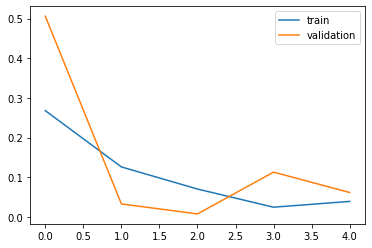

In [15]:
#Generamos plot con los resultados
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Resultados con valores de test

In [16]:
# make a prediction
yhat = model.predict(test_X)

In [17]:
inv_y, inv_yhat = full_prediction(yhat, test_X, test_y)


inv_yhat = scaler.inverse_transform(inv_yhat)
inv_y = scaler.inverse_transform(inv_y)


inv_yhat_df = pd.DataFrame(data=inv_yhat, columns=cols)
inv_y_df = pd.DataFrame(data=inv_y, columns=cols)


inv_y_df['log_ret'] = inv_y_df['Adj Close'].pct_change()


inv_yhat_df['log_ret'] = inv_yhat_df['Adj Close'].pct_change()

In [18]:
inv_y_df

,Adj Close,200ema,50ema,20ema,14-high,14-low,%K,%D,RSI,MACD,...,MACDs,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR,log_ret
0,0.86174,0.858737,0.862893,0.864071,0.8659,0.8624,12.857629,45.449039,43.841574,0.000107,...,0.000325,-210.246471,-0.865900,0.862326,0.863912,0.865499,0.367285,0.165303,0.001376,NaN
1,0.86217,0.858767,0.862847,0.863849,0.8659,0.8614,7.555267,19.026720,38.864898,-0.000085,...,0.000243,-255.546122,-0.865900,0.861133,0.863406,0.865679,0.526416,0.133447,0.001403,0.000499
2,0.86155,0.858801,0.862821,0.863689,0.8659,0.8611,22.291072,14.234656,41.629046,-0.000201,...,0.000154,-193.491974,-0.865720,0.860695,0.863180,0.865665,0.575694,0.296746,0.001392,-0.000719
3,0.86092,0.858828,0.862771,0.863485,0.8659,0.8611,9.374146,13.073495,38.898033,-0.000339,...,0.000056,-148.360981,-0.865443,0.860683,0.862462,0.864241,0.412455,0.243617,0.001374,-0.000731
4,0.86027,0.858849,0.862698,0.863241,0.8659,0.8607,4.230809,11.965342,36.292785,-0.000493,...,-0.000054,-147.734421,-0.865182,0.860559,0.861846,0.863133,0.298579,0.140157,0.001348,-0.000755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0.85755,0.855717,0.857197,0.857380,0.8582,0.8566,62.498137,55.832464,53.553629,0.000093,...,0.000064,40.310240,-0.858091,0.857266,0.857542,0.857818,0.064318,0.605128,0.000842,-0.000058
671,0.85736,0.855736,0.857211,0.857396,0.8582,0.8566,59.376397,55.416480,52.822892,0.000095,...,0.000070,38.361801,-0.858066,0.857299,0.857506,0.857713,0.048169,0.606581,0.000818,-0.000222
672,0.85749,0.855752,0.857217,0.857393,0.8582,0.8566,47.500373,56.458302,50.026294,0.000080,...,0.000072,-24.261354,-0.858040,0.857240,0.857478,0.857716,0.055461,0.251888,0.000793,0.000152
673,0.85730,0.855769,0.857228,0.857402,0.8582,0.8566,55.625093,54.167288,51.902383,0.000078,...,0.000073,-16.649434,-0.858015,0.857241,0.857462,0.857683,0.051558,0.563340,0.000770,-0.000222


In [19]:
inv_yhat_df

,Adj Close,200ema,50ema,20ema,14-high,14-low,%K,%D,RSI,MACD,...,MACDs,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR,log_ret
0,0.870157,0.858737,0.862893,0.864071,0.8659,0.8624,12.857629,45.449039,43.841574,0.000107,...,0.000325,-210.246471,-0.865900,0.862326,0.863912,0.865499,0.367285,0.165303,0.001376,NaN
1,0.869894,0.858767,0.862847,0.863849,0.8659,0.8614,7.555267,19.026720,38.864898,-0.000085,...,0.000243,-255.546122,-0.865900,0.861133,0.863406,0.865679,0.526416,0.133447,0.001403,-0.000303
2,0.869685,0.858801,0.862821,0.863689,0.8659,0.8611,22.291072,14.234656,41.629046,-0.000201,...,0.000154,-193.491974,-0.865720,0.860695,0.863180,0.865665,0.575694,0.296746,0.001392,-0.000240
3,0.869483,0.858828,0.862771,0.863485,0.8659,0.8611,9.374146,13.073495,38.898033,-0.000339,...,0.000056,-148.360981,-0.865443,0.860683,0.862462,0.864241,0.412455,0.243617,0.001374,-0.000232
4,0.869238,0.858849,0.862698,0.863241,0.8659,0.8607,4.230809,11.965342,36.292785,-0.000493,...,-0.000054,-147.734421,-0.865182,0.860559,0.861846,0.863133,0.298579,0.140157,0.001348,-0.000282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0.867096,0.855717,0.857197,0.857380,0.8582,0.8566,62.498137,55.832464,53.553629,0.000093,...,0.000064,40.310240,-0.858091,0.857266,0.857542,0.857818,0.064318,0.605128,0.000842,0.000008
671,0.867082,0.855736,0.857211,0.857396,0.8582,0.8566,59.376397,55.416480,52.822892,0.000095,...,0.000070,38.361801,-0.858066,0.857299,0.857506,0.857713,0.048169,0.606581,0.000818,-0.000016
672,0.867065,0.855752,0.857217,0.857393,0.8582,0.8566,47.500373,56.458302,50.026294,0.000080,...,0.000072,-24.261354,-0.858040,0.857240,0.857478,0.857716,0.055461,0.251888,0.000793,-0.000019
673,0.867057,0.855769,0.857228,0.857402,0.8582,0.8566,55.625093,54.167288,51.902383,0.000078,...,0.000073,-16.649434,-0.858015,0.857241,0.857462,0.857683,0.051558,0.563340,0.000770,-0.000010


In [20]:
a = result(inv_yhat,inv_y)

a

,yhat,y,yhat_log,y_log,res,Resultado
0,0.870157,0.86174,NaN,NaN,NaN,-1
1,0.869894,0.86217,-0.000303,0.000499,-1.509697e-07,-1
2,0.869685,0.86155,-0.000240,-0.000719,1.728746e-07,1
3,0.869483,0.86092,-0.000232,-0.000731,1.698389e-07,1
4,0.869238,0.86027,-0.000282,-0.000755,2.126331e-07,1
...,...,...,...,...,...,...
670,0.867096,0.85755,0.000008,-0.000058,-4.682017e-10,-1
671,0.867082,0.85736,-0.000016,-0.000222,3.527472e-09,1
672,0.867065,0.85749,-0.000019,0.000152,-2.859391e-09,-1
673,0.867057,0.85730,-0.000010,-0.000222,2.242002e-09,1


In [21]:
print(a['Resultado'].value_counts())
print()
per = a['Resultado'].value_counts()[1]/(a['Resultado'].value_counts()[1]+a['Resultado'].value_counts()[-1])
print(f'% acierto: {per}')

-1    341
 1    334
Name: Resultado, dtype: int64

% acierto: 0.4948148148148148


In [22]:
a

,yhat,y,yhat_log,y_log,res,Resultado
0,0.870157,0.86174,NaN,NaN,NaN,-1
1,0.869894,0.86217,-0.000303,0.000499,-1.509697e-07,-1
2,0.869685,0.86155,-0.000240,-0.000719,1.728746e-07,1
3,0.869483,0.86092,-0.000232,-0.000731,1.698389e-07,1
4,0.869238,0.86027,-0.000282,-0.000755,2.126331e-07,1
...,...,...,...,...,...,...
670,0.867096,0.85755,0.000008,-0.000058,-4.682017e-10,-1
671,0.867082,0.85736,-0.000016,-0.000222,3.527472e-09,1
672,0.867065,0.85749,-0.000019,0.000152,-2.859391e-09,-1
673,0.867057,0.85730,-0.000010,-0.000222,2.242002e-09,1
